In [ ]:
import pandas as pd
import numpy as np
import configparser
import os

pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)
## Using an ini file for credentials, otherwise providing defaults
uri = "bolt://localhost:7687"  # Hoặc thay đổi nếu cổng khác
username = "neo4j"  # Tên đăng nhập của Neo4j
password = "12345678"  # Mật khẩu của Neo4j
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(uri, auth=(username, password))
# Machine Learning Training & Evaluation
# Get and Prepare Data
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.sharedIdsDegree AS sharedIdsDegree,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df
# X: Tập dữ liệu đặc trưng đầu vào cho mô hình, loại bỏ các cột không cần thiết:
# Loại bỏ fraudRisk, fraudMoneyTransfer (vì đây là mục tiêu dự đoán).
# Loại bỏ wccId và guid (không mang giá trị cho mô hình học máy).
# X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid', 'p2pSentPageRank', 'p2pReceivedWeightedPageRank','cardDegree','p2pReceivedWeightedDegree', 'p2pSharedCardPageRank', 'deviceDegree'])
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
# y: Biến mục tiêu (target variable):
# df.fraudRisk - df.fraudMoneyTransfer:
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 0 → tài khoản nguy cơ rủi ro → y = 1.
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 1 → tài khoản đã chuyển tiền gian lận → y = 0.
# Nếu fraudRisk = 0 → tài khoản an toàn → y = 0.
y = df.fraudRisk - df.fraudMoneyTransfer

In [1]:
import os
import pickle
from sklearn.model_selection import train_test_split

# Tên file lưu
split_file = "splitted_data.pkl"

if os.path.exists(split_file):
    print("Tải data đã lưu")
    with open(split_file, "rb") as f:
        data_splits = pickle.load(f)
    # Lấy các tập dữ liệu từ dictionary
    X_train = data_splits["X_train"]
    X_val = data_splits["X_val"]
    X_test = data_splits["X_test"]
    y_train = data_splits["y_train"]
    y_val = data_splits["y_val"]
    y_test = data_splits["y_test"]
    X_train_val = data_splits["X_train_val"]
    y_train_val = data_splits["y_train_val"]
else:
    print("Lưu data vào file")
    # Giả sử X và y đã được định nghĩa sẵn
    # Chia dữ liệu thành tập train+val (80%) và test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Chia tiếp tập train_val thành train (75% của train_val) và val (25% của train_val)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )

    # Lưu lại toàn bộ các tập dưới dạng dictionary, bao gồm cả train_val
    data_splits = {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "X_train_val": X_train_val,
        "y_train_val": y_train_val
    }
    
    with open(split_file, "wb") as f:
        pickle.dump(data_splits, f)
    print("Đã lưu vào file: ", split_file)


Tải data đã lưu


In [2]:
import numpy as np  
print("Hình dạng của X_train:", np.array(X_train).shape)
print("Hình dạng của y_train:", np.array(y_train).shape)


Hình dạng của X_train: (20238, 10)
Hình dạng của y_train: (20238,)


In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Định nghĩa cross-validation phù hợp đảm bảo tỷ lệ fraud/non-fraud được giữ nguyên trong mỗi fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Tạo Pipeline gồm 2 bước: SMOTE và Decision Tree
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),        # chuẩn hóa trước
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Grid các siêu tham số, lưu ý thay đổi tên tham số của Decision Tree thành 'dt__'
dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 5, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': ['sqrt', 'log2', None]
}

# Sử dụng GridSearchCV với scoring = 'roc_auc'
dt_grid = GridSearchCV(estimator=pipeline_dt,
                       param_grid=dt_param_grid,
                       cv=cv,
                       scoring='average_precision',
                       n_jobs=-1,
                       verbose=1)

# Huấn luyện mô hình trên tập huấn luyện
dt_grid.fit(X_train_val, y_train_val)

# Lấy mô hình tốt nhất
best_model_dt = dt_grid.best_estimator_
print("Best Parameters:", dt_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_dt.predict(X_test)

# In kết quả đánh giá trên từng tập
print("\nKết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__max_features': None, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}

Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.05      0.48      0.10        42

    accuracy                           0.94      6747
   macro avg       0.53      0.71      0.53      6747
weighted avg       0.99      0.94      0.97      6747



In [11]:
from sklearn.ensemble import RandomForestClassifier

# Tạo Pipeline gồm chuẩn hóa, SMOTE và RandomForest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Grid các siêu tham số với tiền tố 'rf__'
rf_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# GridSearchCV với scoring = 'average_precision' (PR AUC)
rf_grid = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=rf_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện trên tập train/validation
rf_grid.fit(X_train_val, y_train_val)

# Lấy model tốt nhất
best_model_rf = rf_grid.best_estimator_
print("Random Forest - Best Parameters:", rf_grid.best_params_)

# Dự đoán và đánh giá trên tập Test
y_test_pred = best_model_rf.predict(X_test)
print("\nRandom Forest - Test set:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Random Forest - Best Parameters: {'rf__bootstrap': False, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}

Random Forest - Test set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.19      0.14      0.16        42

    accuracy                           0.99      6747
   macro avg       0.59      0.57      0.58      6747
weighted avg       0.99      0.99      0.99      6747



In [12]:
# Sử dụng randomized vì grid quá mất thời gian
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import SVC

# 1. Tạo pipeline gồm: chuẩn hóa → SMOTE → SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))  # dùng probability để hỗ trợ predict_proba nếu cần
])

# 2. Định nghĩa không gian tìm kiếm siêu tham số
svm_random_grid = {
    'svc__C': uniform(0.1, 10),
    'svc__gamma': ['scale'],
    'svc__kernel': ['rbf']
}

# 3. Thiết lập RandomizedSearchCV với scoring = 'average_precision'
svm_search = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=svm_random_grid,
    n_iter=5,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 4. Huấn luyện trên tập train/val
svm_search.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_svm = svm_search.best_estimator_
print("SVM - Best Parameters:", svm_search.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_svm.predict(X_test)

# 7. Đánh giá mô hình
print("\nSVM - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
SVM - Best Parameters: {'svc__C': 1.6601864044243653, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

SVM - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      6705
           1       0.03      0.90      0.06        42

    accuracy                           0.82      6747
   macro avg       0.52      0.86      0.48      6747
weighted avg       0.99      0.82      0.90      6747



In [20]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Tạo pipeline gồm: chuẩn hóa → SMOTE → KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# 2. Định nghĩa không gian siêu tham số
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

# 3. Sử dụng GridSearchCV với scoring = 'average_precision' (PR AUC)
knn_grid = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=knn_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện mô hình trên tập train/validation
knn_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_knn = knn_grid.best_estimator_
print("KNN - Best Parameters:", knn_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_knn.predict(X_test)

# 7. Đánh giá trên tập test
print("\nKNN - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))



Fitting 5 folds for each of 16 candidates, totalling 80 fits
KNN - Best Parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}

KNN - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6705
           1       0.07      0.38      0.12        42

    accuracy                           0.97      6747
   macro avg       0.53      0.68      0.55      6747
weighted avg       0.99      0.97      0.98      6747



In [21]:
from sklearn.naive_bayes import GaussianNB

# 1. Tạo pipeline gồm: chuẩn hóa → SMOTE → GaussianNB
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('nb', GaussianNB())
])

# 2. Định nghĩa không gian siêu tham số
nb_param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7]
}

# 3. Thiết lập GridSearchCV với scoring = 'average_precision'
nb_grid = GridSearchCV(
    estimator=pipeline_nb,
    param_grid=nb_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện mô hình trên tập train/val
nb_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_nb = nb_grid.best_estimator_
print("Naïve Bayes - Best Parameters:", nb_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_nb.predict(X_test)

# 7. Đánh giá mô hình
print("\nNaïve Bayes - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Naïve Bayes - Best Parameters: {'nb__var_smoothing': 1e-07}

Naïve Bayes - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84      6705
           1       0.02      0.95      0.04        42

    accuracy                           0.73      6747
   macro avg       0.51      0.84      0.44      6747
weighted avg       0.99      0.73      0.84      6747



In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# 1. Tạo pipeline: chuẩn hóa → SMOTE → Bagging(DecisionTree)
pipeline_bag = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('bag', BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42))
])

# 2. Không gian siêu tham số cho Bagging
bagging_param_grid = {
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 1.0],
    'bag__max_features': [0.5, 1.0],
    'bag__bootstrap': [True, False]
}

# 3. GridSearchCV với scoring = 'average_precision'
bagging_grid = GridSearchCV(
    estimator=pipeline_bag,
    param_grid=bagging_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện trên tập train/val
bagging_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_bag = bagging_grid.best_estimator_
print("Bagging - Best Parameters:", bagging_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_bag.predict(X_test)

# 7. Đánh giá mô hình
print("\nBagging - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Bagging - Best Parameters: {'bag__bootstrap': False, 'bag__max_features': 0.5, 'bag__max_samples': 1.0, 'bag__n_estimators': 100}

Bagging - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.80      0.10      0.17        42

    accuracy                           0.99      6747
   macro avg       0.90      0.55      0.58      6747
weighted avg       0.99      0.99      0.99      6747



In [23]:
from xgboost import XGBClassifier

# 1. Tạo pipeline: chuẩn hóa → SMOTE → XGBoost
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
])

# 2. Định nghĩa không gian siêu tham số
xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# 3. Thiết lập GridSearchCV
xgb_grid = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=xgb_param_grid,
    cv=cv,  
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện mô hình trên tập train/val
xgb_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_xgb = xgb_grid.best_estimator_
print("XGBoost - Best Parameters:", xgb_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_xgb.predict(X_test)

# 7. Đánh giá kết quả
print("\nXGBoost - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
XGBoost - Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}

XGBoost - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6705
           1       0.09      0.36      0.15        42

    accuracy                           0.97      6747
   macro avg       0.54      0.67      0.57      6747
weighted avg       0.99      0.97      0.98      6747



C:\Users\ASUS\PycharmProjects\Graph Neural Network\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Decision tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6705
           1       0.14      0.14      0.14        42

    accuracy                           0.99      6747
   macro avg       0.57      0.57      0.57      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix:


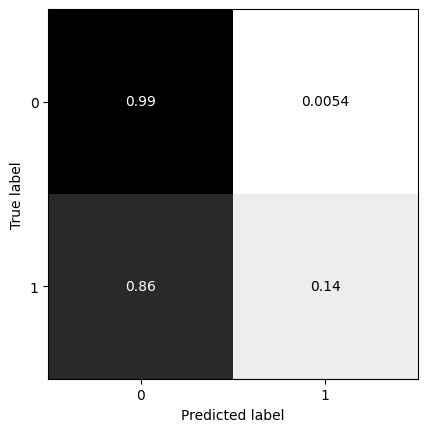

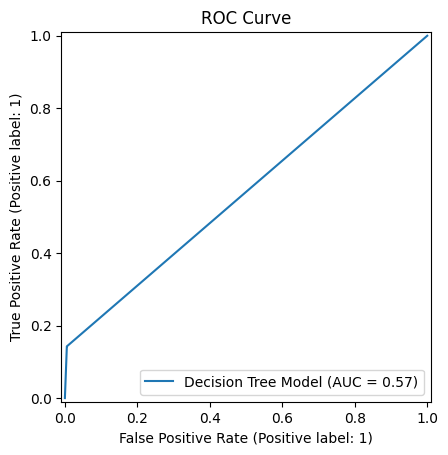

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Khởi tạo mô hình Decision Tree với các tham số tương tự Random Forest
dt_model = DecisionTreeClassifier()

# Huấn luyện mô hình
dt_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_dt = dt_model.predict(X_test)

# In kết quả
print("\nDecision tree:")
print(classification_report(y_test, y_pred_dt, zero_division=0))

# Hiển thị ma trận nhầm lẫn
print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_dt, display_labels=dt_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(dt_model, X_test, y_test, name="Decision Tree Model")
_ = display.ax_.set_title("ROC Curve")


Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       1.00      0.07      0.13        42

    accuracy                           0.99      6747
   macro avg       1.00      0.54      0.57      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix:


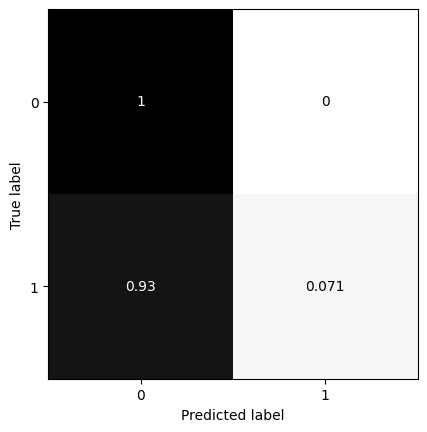

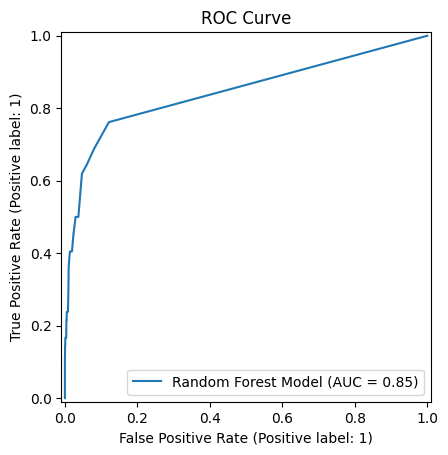

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Khởi tạo mô hình Random Forest (sử dụng random_state để tái lập kết quả)
rf_model = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình
rf_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)

# In kết quả (classification report)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Hiển thị ma trận nhầm lẫn
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=rf_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)
plt.show()

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest Model")
_ = display.ax_.set_title("ROC Curve")
plt.show()



SVM (RBF Kernel):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.00      0.00      0.00        42

    accuracy                           0.99      6747
   macro avg       0.50      0.50      0.50      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix:


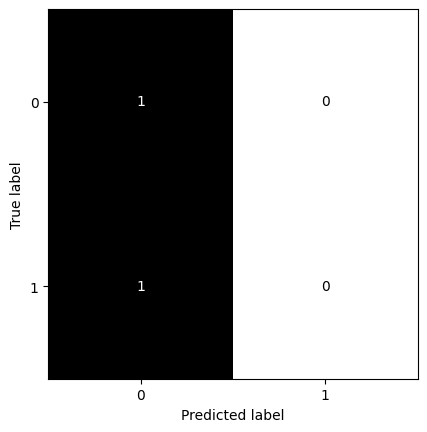

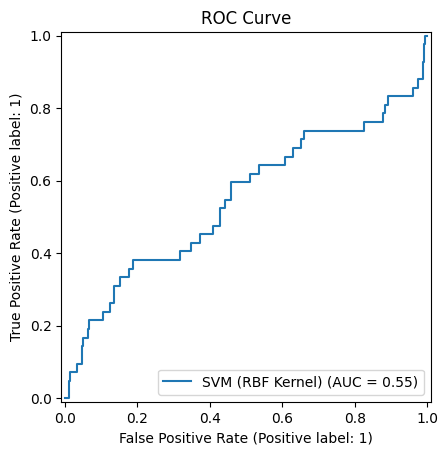

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Khởi tạo mô hình SVM với kernel RBF và probability=True để có thể sử dụng ROC Curve
svm_model = SVC(probability=True, kernel='rbf', random_state=42)

# Huấn luyện mô hình
svm_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_svm = svm_model.predict(X_test)

# In kết quả (classification report)
print("\nSVM (RBF Kernel):")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Hiển thị ma trận nhầm lẫn
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_svm, display_labels=svm_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)
plt.show()

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(svm_model, X_test, y_test, name="SVM (RBF Kernel)")
_ = display.ax_.set_title("ROC Curve")
plt.show()




KNN:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       1.00      0.05      0.09        42

    accuracy                           0.99      6747
   macro avg       1.00      0.52      0.54      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix:


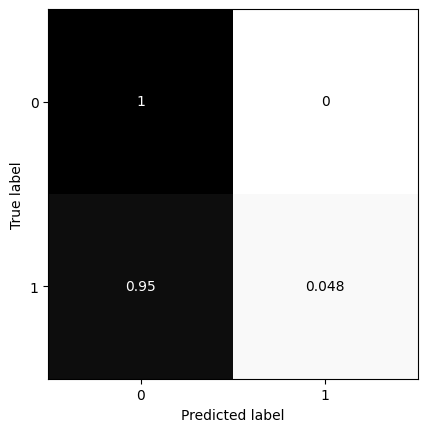

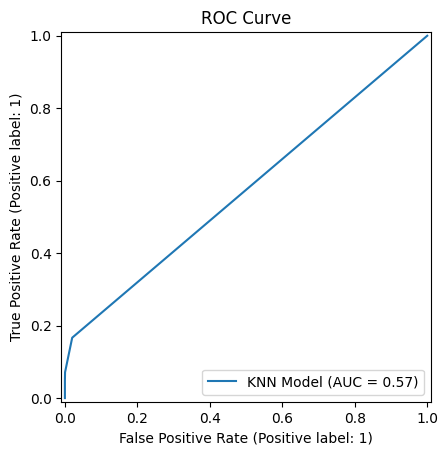

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Khởi tạo mô hình KNN (mặc định)
knn_model = KNeighborsClassifier()

# Huấn luyện mô hình
knn_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_knn = knn_model.predict(X_test)

# In kết quả (classification report)
print("\nKNN:")
print(classification_report(y_test, y_pred_knn, zero_division=0))

# Hiển thị ma trận nhầm lẫn
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn, display_labels=knn_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)
plt.show()

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(knn_model, X_test, y_test, name="KNN Model")
_ = display.ax_.set_title("ROC Curve")
plt.show()



MLP:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.00      0.00      0.00        42

    accuracy                           0.99      6747
   macro avg       0.50      0.50      0.50      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix:


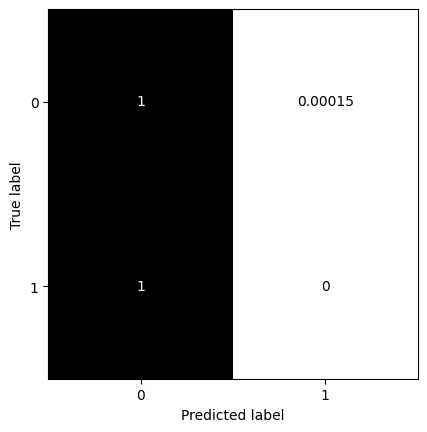

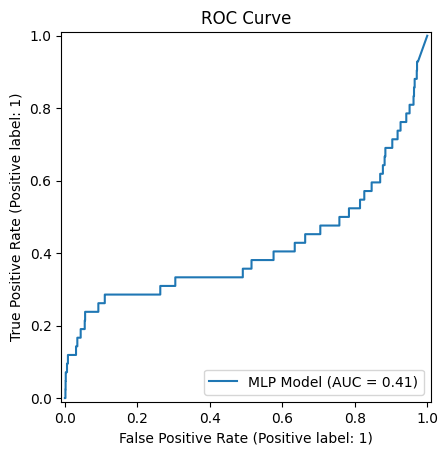

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Khởi tạo mô hình MLP với các tham số mặc định (với random_state và max_iter để đảm bảo hội tụ)
mlp_model = MLPClassifier(random_state=42, max_iter=1000)

# Huấn luyện mô hình
mlp_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_mlp = mlp_model.predict(X_test)

# In kết quả (classification report)
print("\nMLP:")
print(classification_report(y_test, y_pred_mlp, zero_division=0))

# Hiển thị ma trận nhầm lẫn
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_mlp, display_labels=mlp_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)
plt.show()

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(mlp_model, X_test, y_test, name="MLP Model")
_ = display.ax_.set_title("ROC Curve")
plt.show()



Naive Bayes:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6705
           1       0.02      0.05      0.02        42

    accuracy                           0.98      6747
   macro avg       0.51      0.51      0.51      6747
weighted avg       0.99      0.98      0.98      6747


Confusion Matrix:


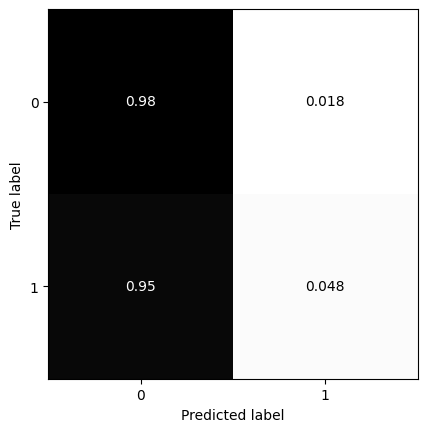

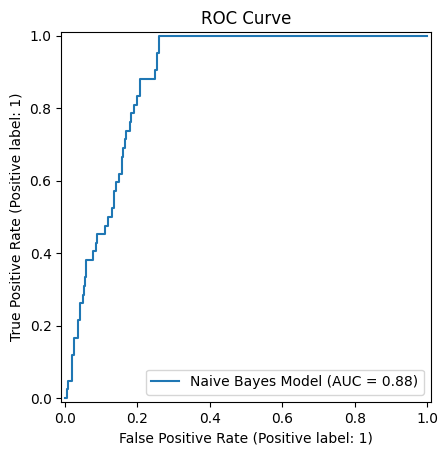

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Khởi tạo mô hình Naive Bayes
nb_model = GaussianNB()

# Huấn luyện mô hình
nb_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test)

# In kết quả (classification report)
print("\nNaive Bayes:")
print(classification_report(y_test, y_pred_nb, zero_division=0))

# Hiển thị ma trận nhầm lẫn
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_nb, display_labels=nb_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)
plt.show()

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(nb_model, X_test, y_test, name="Naive Bayes Model")
_ = display.ax_.set_title("ROC Curve")
plt.show()



Bagging Classifier:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.38      0.07      0.12        42

    accuracy                           0.99      6747
   macro avg       0.68      0.54      0.56      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix:


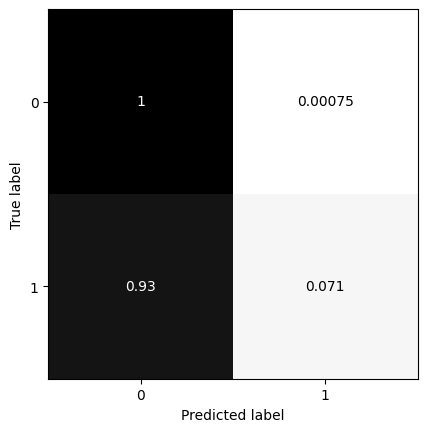

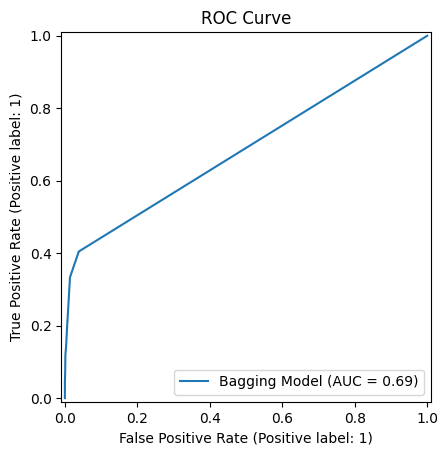

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Khởi tạo mô hình Bagging (sử dụng mặc định, nếu cần bạn có thể chỉ định base_estimator)
bagging_model = BaggingClassifier(random_state=42)

# Huấn luyện mô hình
bagging_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_bag = bagging_model.predict(X_test)

# In kết quả (classification report)
print("\nBagging Classifier:")
print(classification_report(y_test, y_pred_bag, zero_division=0))

# Hiển thị ma trận nhầm lẫn (normalize='true')
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_bag, display_labels=bagging_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)
plt.show()

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(bagging_model, X_test, y_test, name="Bagging Model")
_ = display.ax_.set_title("ROC Curve")
plt.show()
